In [1]:
%load_ext dotenv
%dotenv 


In [2]:
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
from utils.logger import get_logger
_logs = get_logger(__name__)

In [3]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

c:\Users\Andrea\miniconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(os.path.join(ft_dir, '**/*.parquet'), 
               recursive = True)
df = dd.read_parquet(ft_glob).compute().reset_index()

# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [5]:
df.sample(n = 5)

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Returns
75697,GLUU,2015-11-27,3.39000,3.430000,3.36000,3.430000,3.430000,551200.0,GLUU.csv,2015,3.390000,0.011799
53798,EARN,2016-11-03,12.35000,12.540000,12.35000,12.380000,8.095041,47900.0,EARN.csv,2016,12.340000,0.003241
187069,SYNH,2017-02-23,54.50000,56.049999,54.50000,55.700001,55.700001,334600.0,SYNH.csv,2017,54.549999,0.021082
157089,REI,2007-09-07,11.70000,11.700000,11.70000,11.700000,11.700000,0.0,REI.csv,2007,11.700000,0.000000
228603,WST,1988-01-18,4.21875,4.281250,4.21875,4.250000,0.652500,20000.0,WST.csv,1988,4.187500,0.014925


In [ ]:
import random
random.seed(42)
sample_tickers = random.sample(df['ticker'].unique().tolist(), 30) # grabbing a sample of 30 tickers
df = df[df['ticker'].isin(sample_tickers)]
simple_sample_dt = df.sample(frac = 0.1) # sample of 10%
simple_sample_dt.shape, df.shape

((10334, 12), (103335, 12))

Look at the distribution of tickers.

<Axes: xlabel='ticker'>

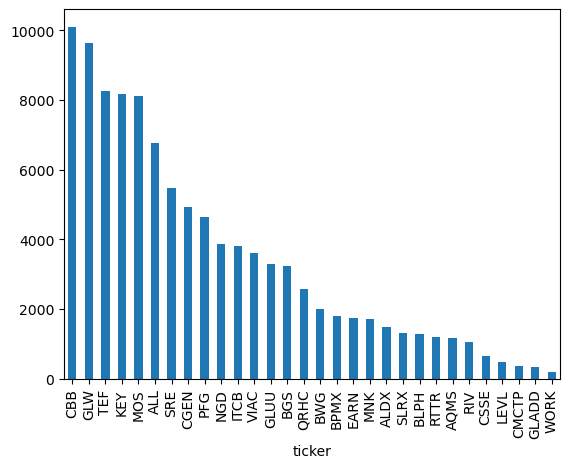

In [ ]:
df['ticker'].value_counts().plot(kind='bar') 
# from 30 randomly sampled tickers, count the number of times each ticker appears

<Axes: xlabel='ticker'>

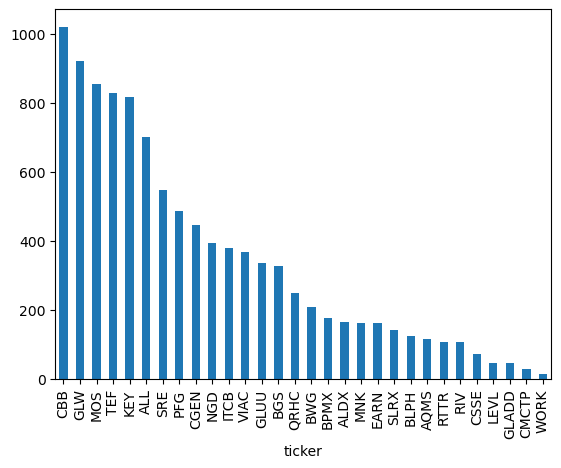

In [9]:
simple_sample_dt['ticker'].value_counts().plot(kind='bar')

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: xlabel='ticker'>

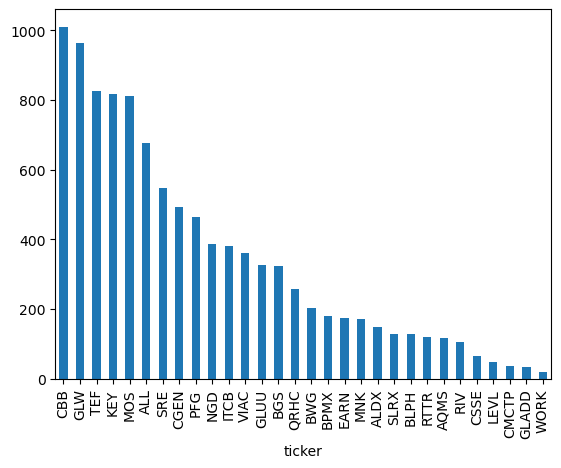

In [11]:
strat_sample_dt = df.groupby(['ticker']).sample(frac = 0.1) # within each ticker group, take 10% of the sample
strat_sample_dt['ticker'].value_counts().plot(kind='bar')

# guarantees exactly the same distribution of ticker count (thanks to group by, and then sampling)

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

C:\Users\Andrea\AppData\Local\Temp\ipykernel_15248\4277172002.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  strat_sample_dd = (dd_dt


<Axes: xlabel='ticker'>

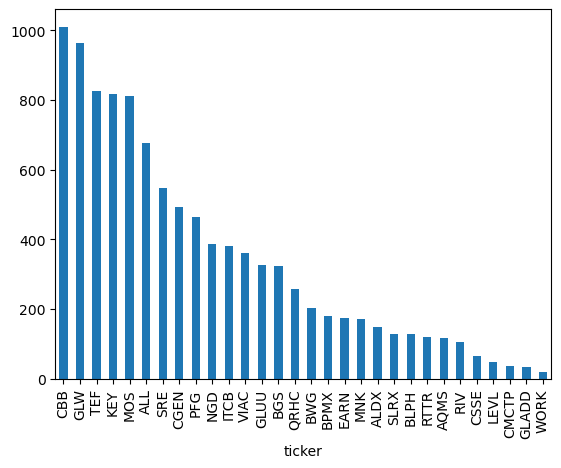

In [12]:
# lumping everything into single operation

dd_dt = dd.read_parquet(ft_glob) # read dataframe
strat_sample_dd = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1)) # group by
                      .compute() # need to compute
                      .reset_index()) # remove the index
strat_sample_dd[strat_sample_dd['ticker'].isin(sample_tickers)]['ticker'].value_counts().plot(kind='bar')